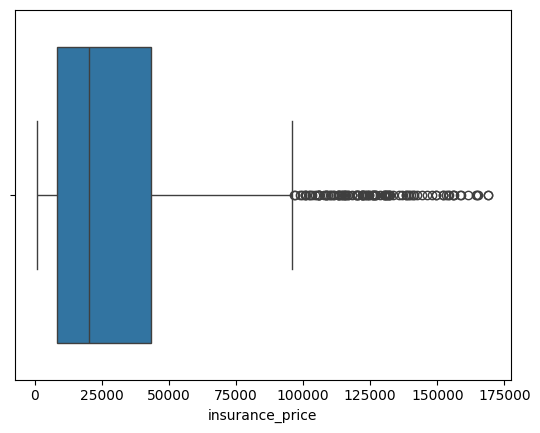

<Figure size 800x400 with 0 Axes>

╒══════╤═══════╤═══════╤════════════╤════════════╤═══════════════════╤════════════╤══════════════╤════════════════════╤════════════════════╤════════════════════╤══════════════╕
│      │   age │   bmi │   children │   expenses │   insurance_price │   sex_male │   smoker_yes │   region_northwest │   region_southeast │   region_southwest │      z_score │
╞══════╪═══════╪═══════╪════════════╪════════════╪═══════════════════╪════════════╪══════════════╪════════════════════╪════════════════════╪════════════════════╪══════════════╡
│    0 │    19 │    27 │          0 │      16884 │             42112 │          0 │            1 │                  0 │                  0 │                  1 │  0.0932406   │
├──────┼───────┼───────┼────────────┼────────────┼───────────────────┼────────────┼──────────────┼────────────────────┼────────────────────┼────────────────────┼──────────────┤
│    1 │    18 │    33 │          1 │       1725 │              1968 │          1 │            0 │                 

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tabulate import tabulate
from scipy.stats import skew

#1339 filas
df = pd.read_csv('../csvs/insurance.csv')
#.strip() coge todas las columnas en este caso de texto y le quita los espacios en blanco.
df.columns = df.columns.str.strip()
np.random.seed(42)

centil = pd.qcut(df['expenses'], q=100, labels=False)
expenses = df['expenses']
incremento = 1 + (centil * 0.01)
precio_base = expenses * incremento
df['insurance_price'] = precio_base

def ajustar_precio(fila):
    precio = fila['insurance_price']  
    #Edad
    if fila['age'] < 25:
        precio *= 0.75  # 25% de descuento
    elif fila['age'] > 75:
        precio *= 1.40  # 40% de incremento
    elif fila['age'] > 50:
        precio *= 1.25  # 25% de incremento

    #Sexo
    if fila['sex'] == 'female':
        if 18 <= fila['age'] <= 45:
            precio *= 1.22  # 22% de incremento
        elif fila['age'] > 45:
            precio *= 1.17  # 17% de incremento

    #BMI
    if fila['bmi'] < 18.5:
        precio *= 1.17  # 17% de incremento
    elif 25 <= fila['bmi'] < 30:
        precio *= 1.20  # 20% de incremento
    elif fila['bmi'] >= 30:
        precio *= 1.25  # 25% de incremento

    #Smoker
    if fila['smoker'] == 'yes':
        precio *= 1.10  # 10% de incremento

    #Región
    if fila['region'] == 'northeast': # 16% de incremento
        precio *= 1.16
    elif fila['region'] == 'southwest': # 18% de incremento
        precio *= 1.18
    elif fila['region'] == 'southeast': # 17% de incremento
        precio *= 1.17
    return precio

df['insurance_price'] = df.apply(ajustar_precio, axis=1)
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
df_encoded = df_encoded.astype(int)

#sns.boxplot(x=df_encoded['insurance_price'])
df_encoded['z_score'] = zscore(df_encoded['insurance_price'])
df_sin_outliers = df_encoded[(df_encoded['z_score'].abs() <= 3)]
sns.boxplot(x=df_sin_outliers['insurance_price'])
plt.figure(figsize=(8,4))
#print("Valores atípicos detectados:\n", outliers)
#print("Skewness:", skew(df_encoded['insurance_price']))
plt.show()
#print("Correlacion :", df_encoded.corr())
print(tabulate(df_sin_outliers, headers='keys', tablefmt='fancy_grid'))

print(df_sin_outliers['insurance_price'].describe())


In [32]:
# División 80/20
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_sin_outliers.drop(columns=['insurance_price', 'z_score']).values
y = df_sin_outliers['insurance_price'].values

# Suponiendo que tenemos un DataFrame con X (variables) e y (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Datos de entrenamiento:", len(X_train))
print("Datos de prueba:", len(X_test))

# Crear modelo de regresión
modelo = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluamos el modelo con métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")


Datos de entrenamiento: 1040
Datos de prueba: 260
Error cuadrático medio (MSE): 53599435.42
Coeficiente de determinación (R²): 0.96


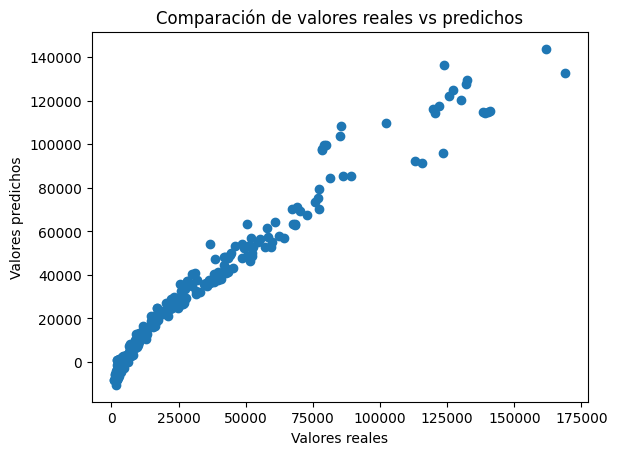

In [30]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Comparación de valores reales vs predichos")
plt.show()
